In [3]:
from google.colab import userdata
openai_api_key = userdata.get("openai_apikey")

In [90]:
%%shell
pip install openai langchain chromadb tiktoken faiss-cpu kaggle lark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 1.9 MB/s eta 0:00:00


In [1]:
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from openai import OpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma, FAISS
from langchain.docstore import InMemoryDocstore
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
from langchain.memory import (
    ConversationBufferMemory, ConversationBufferWindowMemory,
    ConversationEntityMemory, ConversationKGMemory,
    ConversationSummaryMemory, VectorStoreRetrieverMemory
)
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import ConversationChain, LLMChain, SequentialChain
from langchain.memory.prompt import ENTITY_MEMORY_CONVERSATION_TEMPLATE
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo
from typing import TypeVar, Dict

plt.style.use("ggplot")

In [2]:
T = TypeVar("T", covariant=True)

# Embeddings

In [ ]:
client = OpenAI(api_key=openai_api_key)

In [ ]:
texts = [
    "The dogs are domestic animals that are really friendly",
    "Cats are domestic animals that are idependent",
    "Tigers are wild predators that live in the wild"
]

In [ ]:
result = client.embeddings.create(input=texts, model="text-embedding-ada-002")

In [ ]:
type(result.data)

list

In [ ]:
len(result.data)

3

In [ ]:
vects = np.concatenate(
    list(
        map(
            lambda x: np.array(x.embedding).reshape(1, -1),
            result.data
            )
        )
    )


In [ ]:
vects.shape

(3, 1536)

In [ ]:
#sims = cosine_similarity(vects)
sims = euclidean_distances(vects)

In [ ]:
sims.shape

(3, 3)

In [ ]:
df = pd.DataFrame(
    data=sims,
    columns=(cols := [f"text {i}" for i in range(1, 4)]),
    index=cols
    )

In [ ]:
df

,text 1,text 2,text 3
text 1,0.000000,0.505978,0.617292
text 2,0.505978,0.000000,0.563183
text 3,0.617292,0.563183,0.000000


<Axes: >

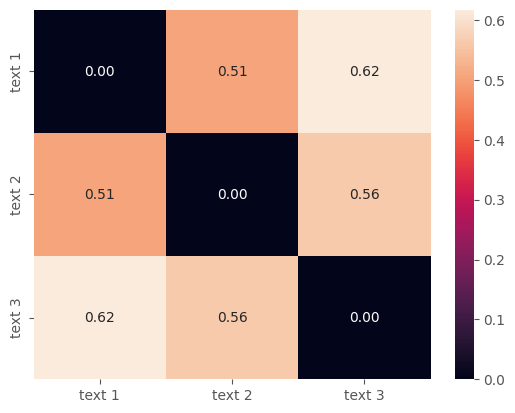

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(df, annot=True, ax=ax, fmt=".2f")

# Vector Database

In [ ]:
%%writefile corpus.txt
The dogs are domestic animals that are really friendly
Cats are domestic animals that are idependent
Tigers are wild predators that live in the wild

Writing corpus.txt


In [ ]:
loader = TextLoader("corpus.txt")
loader

In [ ]:
doc = loader.load()

In [ ]:
doc

[Document(page_content='The dogs are domestic animals that are really friendly\nCats are domestic animals that are idependent\nTigers are wild predators that live in the wild\n', metadata={'source': 'corpus.txt'})]

In [ ]:
splitter = CharacterTextSplitter(separator=r"\\n", is_separator_regex=True)

In [ ]:
docs = splitter.split_documents(doc)

In [ ]:
docs

[Document(page_content='The dogs are domestic animals that are really friendly\nCats are domestic animals that are idependent\nTigers are wild predators that live in the wild', metadata={'source': 'corpus.txt'})]

In [ ]:
type(doc[0])

langchain_core.documents.base.Document

In [ ]:
texts

['The dogs are domestic animals that are really friendly',
 'Cats are domestic animals that are idependent',
 'Tigers are wild predators that live in the wild']

In [ ]:
docs = []
for text in texts:
    docs.append(Document(page_content=text))

In [ ]:
docs

[Document(page_content='The dogs are domestic animals that are really friendly'),
 Document(page_content='Cats are domestic animals that are idependent'),
 Document(page_content='Tigers are wild predators that live in the wild')]

In [ ]:
db = Chroma.from_documents(
    documents=docs,
    embedding=OpenAIEmbeddings(openai_api_key=openai_api_key)
)

In [ ]:
db

In [ ]:
db.similarity_search(
    query="my cat is so cute",
    k=1
)

[Document(page_content='Cats are domestic animals that are idependent')]

# Memoria Buffer

In [ ]:
memory = ConversationBufferMemory(memory_key="history", human_prefix="- Human: ", ai_prefix="- AI: ")

In [ ]:
memory.save_context({"input": "Hello"}, {"output": "Hello, my name is Jeff"})

In [ ]:
memory.chat_memory

ChatMessageHistory(messages=[HumanMessage(content='Hello'), AIMessage(content='Hello, my name is Jeff')])

In [ ]:
memory.load_memory_variables({})

{'history': '- Human: : Hello\n- AI: : Hello, my name is Jeff'}

In [ ]:
llm = OpenAI(openai_api_key=openai_api_key)

In [ ]:
template = """
This is a conversation between two persons

[historical]
{history}

[message]
{message}

[response]
"""
prompt = PromptTemplate(template=template, input_variables=["history", "message"])

In [ ]:
prompt

PromptTemplate(input_variables=['history', 'message'], template='\nThis is a conversation between two persons\n\n[historical]\n{history}\n\n[message]\n{message}\n\n[response]\n')

In [ ]:
chain = LLMChain(
    llm=llm,
    prompt=prompt,
    memory=memory
)

In [ ]:
chain.run({"message": "What's your name?"})

'My name is Jeff.'

In [ ]:
memory.load_memory_variables({})

{'history': "- Human: : Hello\n- AI: : Hello, my name is Jeff\n- Human: : What's your name?\n- AI: : My name is Jeff."}

In [ ]:
chain.run({"message": "How old are you?"})

'I am a program and do not have an age.'

In [ ]:
memory.load_memory_variables({})

{'history': "- Human: : Hello\n- AI: : Hello, my name is Jeff\n- Human: : What's your name?\n- AI: : My name is Jeff.\n- Human: : How old are you?\n- AI: : I am a program and do not have an age."}

# Memoria Rotativa

In [ ]:
memory = ConversationBufferWindowMemory(k=2)
memory.save_context({"input": "Hi"}, {"output": "Hello"})
memory.save_context({"input": "My name is Julian"}, {"output": "Nice to meet you! I'm Dylan"})

In [ ]:
memory.load_memory_variables({})

{'history': "Human: Hi\nAI: Hello\nHuman: My name is Julian\nAI: Nice to meet you! I'm Dylan"}

In [ ]:
memory.save_context({"input": "I'm 20 year old, and you?"}, {"output": "I'm too old for you"})

In [ ]:
memory.load_memory_variables({})

{'history': "Human: My name is Julian\nAI: Nice to meet you! I'm Dylan\nHuman: I'm 20 year old, and you?\nAI: I'm too old for you"}

In [ ]:
chain = LLMChain(
    llm=llm,
    prompt=prompt,
    memory=memory
)

In [ ]:
chain.run({"message": "I'm a developer, and you?"})

"AI: I'm a software engineer. It's nice to meet you!"

In [ ]:
chain.run({"message": "Can you remind me your name?"})

"AI: Sure, my name is AI. It's nice to meet you!"

In [ ]:
memory.load_memory_variables({})

{'history': "Human: I'm a developer, and you?\nAI: AI: I'm a software engineer. It's nice to meet you!\nHuman: Can you remind me your name?\nAI: AI: Sure, my name is AI. It's nice to meet you!"}

In [ ]:
import inspect

In [ ]:
inspect.getmro(ConversationBufferMemory)

(langchain.memory.buffer.ConversationBufferMemory,
 langchain.memory.chat_memory.BaseChatMemory,
 langchain_core.memory.BaseMemory,
 langchain_core.load.serializable.Serializable,
 pydantic.main.BaseModel,
 pydantic.utils.Representation,
 abc.ABC,
 object)

In [ ]:
from langchain_core.memory import BaseMemory
isinstance(memory, BaseMemory)

True

# Entidad

In [ ]:
memory = ConversationEntityMemory(llm=llm)

In [ ]:
inp = {
    "input": "el estudiante Nicolai de 9no semestre del programa de ciencias de la computacion esta desarrollando un proyecto de grado relacionado a IA"
}

In [ ]:
memory.load_memory_variables(inp)

{'history': '',
 'entities': {'Nicolai': '',
  '9no': '',
  'Ciencias de la Computación': '',
  'IA': ''}}

In [ ]:
memory.save_context(
    inp,
    {"output": "Maravilloso, me gustaria conocer a Nicolai y trabajar con el"}
)

In [ ]:
memory.load_memory_variables({"input": "Que es IA?"})

{'history': 'Human: el estudiante Nicolai de 9no semestre del programa de ciencias de la computacion esta desarrollando un proyecto de grado relacionado a IA\nAI: Maravilloso, me gustaria conocer a Nicolai y trabajar con el',
 'entities': {}}

In [ ]:
ENTITY_MEMORY_CONVERSATION_TEMPLATE

PromptTemplate(input_variables=['entities', 'history', 'input'], template='You are an assistant to a human, powered by a large language model trained by OpenAI.\n\nYou are designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, you are able to generate human-like text based on the input you receive, allowing you to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.\n\nYou are constantly learning and improving, and your capabilities are constantly evolving. You are able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. You have access to some personalized information provided by the human in the Context section below. Additionally, you are able to generate your own text based on the input you

In [ ]:
chain = ConversationChain(
    llm=llm,
    prompt=ENTITY_MEMORY_CONVERSATION_TEMPLATE,
    memory=ConversationEntityMemory(llm=llm)
)

In [ ]:
chain.run({"input": "John and Mary are studing math and they are in a relationship, they enjoy playing videogames and other academic activities"})

" That sounds like a great way to balance both academic and recreational interests! Do you have any specific questions about John and Mary's relationship that I can help answer?"

In [ ]:
chain.memory.load_memory_variables({"input": "Who are John and Mary?"})

{'history': "Human: John and Mary are studing math and they are in a relationship, they enjoy playing videogames and other academic activities\nAI:  That sounds like a great way to balance both academic and recreational interests! Do you have any specific questions about John and Mary's relationship that I can help answer?",
 'entities': {'John': 'John is in a relationship with Mary and they both enjoy studying math and playing videogames.',
  'Mary': 'Mary is in a relationship with John and they both enjoy studying math and playing videogames.'}}

# Knowledge Graph

In [ ]:
memory = ConversationKGMemory(llm=llm, memory_key="history")

In [ ]:
memory.save_context({"input": "Te presento a Pedro"}, {"output": "Quien es Pedro?"})
memory.save_context({"input": "Pedro es mi amigo"}, {"output": "Quien eres tu?"})
memory.save_context({"input": "Yo soy Juan"}, {"output": "Entendido"})

In [ ]:
memory.load_memory_variables({"input": "Quien es Pedro?"})

{'history': 'On Pedro: Pedro es amigo. Pedro es de Human.'}

In [ ]:
memory = ConversationKGMemory(llm=llm, memory_key="history")

In [ ]:
template = """
Esta es una conversacion entre una persona y una IA que extrae informacion util.
Si la IA no sabe la respuesta, lo debe expresar de forma explicita y preguntar por mas informacion.
La IA unicamente utiliza informacion contenida dentro de la seccion "HISTORY" y el mensaje nuevo "MESSAGE".

[HISTORY]
{history}

[MESSAGE]
{message}

[RESPONSE]
"""
prompt = PromptTemplate(template=template, input_variables=["history", "message"])

In [ ]:
chain = LLMChain(
    llm=llm,
    prompt=prompt,
    memory=memory,
)

In [ ]:
chain.run({"message": "Ayer conoci a una chica llamada Valentina, ella es medica"})

'¡Qué interesante! ¿Qué tipo de medicina especializa Valentina?'

In [ ]:
chain.run({"message": "Ella se especializa en pediatria y ahi interactua con Pepito y Manuelito"})

'Gracias por compartir esta información. Entiendo que Valentina trabaja como médico pediatra y se encuentra en contacto con Pepito y Manuelito. ¿Puede indicarme cómo los conoció?'

In [ ]:
chain.memory.load_memory_variables({"message": "Quien es Valentina?"})

{'history': 'On Valentina: Valentina is a medical doctor. Valentina specializes in pediatrics. Valentina interacts with Pepito. Valentina interacts with Manuelito.'}

In [ ]:
chain.memory.load_memory_variables({"message": "Quien es Pepito?"})

{'history': ''}

In [ ]:
chain.run({"message": "Los conocio en una consulta de pediatria"})

'Entiendo que Valentina conoció a Pepito y Manuelito en una consulta de pediatría. ¿Tienen alguna otra información sobre el lugar donde conoció a estas dos personas?'

In [ ]:
chain.memory.load_memory_variables({"message": "Quien es Valentina?"})

{'history': 'On Valentina: Valentina is a medical doctor. Valentina specializes in pediatrics. Valentina conocio Pepito. Valentina conocio Manuelito. Valentina conoció en consulta de pediatría.'}

# Memoria Resumen

In [ ]:
memory = ConversationSummaryMemory(llm=llm)

In [ ]:
memory.save_context({"input": "Hola, te cuento mi dia hoy estuve trabajando desde temprano, avance en el proyecto relacionado con finanzas. Almorce fuera de la oficina y fui a un restaurante nuevo donde probe un plato vegetariano. Luego volvi al trabajo y aqui estoy"}, {"output": "Interesante, como te sientes?"})
memory.save_context({"input": "Me siento tranquilo, las emociones estan estables y todo se encuentra controlado"}, {"output": "Me alegra mucho"})

In [ ]:
memory.load_memory_variables({})

{'history': '\n\nThe human shared about their day, having worked from early on a financial project and having lunch at a new restaurant where they tried a vegetarian dish. The AI is interested, and asked the human how they feel. The human responded that they feel calm, their emotions are stable, and everything is under control. The AI expressed its joy.'}

In [ ]:
memory.predict_new_summary(
    messages=memory.chat_memory.messages,
    existing_summary="The Human and the AI are in a friendship, and they share their feelings every day."
)

'\nThe Human and the AI are in a friendship, and they share their feelings every day. The Human shared their day, which included working on a finance project, eating a vegetarian meal at a new restaurant, and feeling calm and in control. The AI was glad to hear it.'

In [ ]:
memory = ConversationSummaryMemory(llm=llm, memory_key="history")
template = """
You store numbers

[history]
{history}

[message]
{message}

[response]
"""
prompt = PromptTemplate(template=template, input_variables=["history", "message"])

In [ ]:
chain = LLMChain(
    llm=llm,
    prompt=prompt,
    memory=memory
)

In [ ]:
chain.run({"message": "Remember the number 288238832"})
chain.run({"message": "Remember the password uaUthUasohteUa"})

'I have stored the password uaUthUasohteUa.'

In [ ]:
chain.run({"message": "How is the number that I gave you?"})

'The number you gave me is stored in my memory and is 288238832.'

In [ ]:
memory.load_memory_variables({})

{'history': '\nThe human asks the AI to remember the number 288238832 and the password uaUthUasohteUa, and the AI confirms that it has stored both. The human then asks the AI to recall the number, to which the AI confirms that it is 288238832. The human also asks how the number is, to which the AI confirms that it is stored in its memory and is 288238832.'}

# Memoria de VectorDB

In [4]:
embedding_dim = 1536

In [5]:
index = faiss.IndexFlatL2(embedding_dim)

In [8]:
embedding = OpenAIEmbeddings(openai_api_key=openai_api_key)

In [13]:
db = FAISS(
    embedding_function=embedding,
    index=index,
    docstore=InMemoryDocstore({}),
    index_to_docstore_id={}
)

In [23]:
retriever = db.as_retriever(search_kwargs={"k": 2})

In [24]:
memory = VectorStoreRetrieverMemory(
    retriever=retriever, memory_key="history"
    )

In [25]:
memory.save_context({"input": "Mi color favorito es el negro"}, {"output": "Guardado"})
memory.save_context({"input": "Me gusta jugar videojuegos"}, {"output": "Guardado"})
memory.save_context({"input": "No me gustan los deportes"}, {"output": "Guardado"})
memory.save_context({"input": "No me gustan las caminatas"}, {"output": "Guardado"})

In [26]:
memory.load_memory_variables({"input": "Que no me gusta?"})

{'history': 'input: No me gustan los deportes\noutput: Guardado\ninput: No me gustan los deportes\noutput: Guardado'}

In [15]:
index = faiss.IndexFlatL2(embedding_dim)
db = FAISS(
    embedding_function=embedding,
    index=index,
    docstore=InMemoryDocstore({}),
    index_to_docstore_id={}
)

In [16]:
retriever = db.as_retriever(search_kwargs={"k": 1})
memory = VectorStoreRetrieverMemory(
    retriever=retriever, memory_key="history"
    )
memory.save_context({"input": "Mi nombre es Juan"}, {"output": "Guardado"})

In [17]:
template = """
Te encargas de guardar informacion personal de una persona. Puedes tomar informacion
relevante de la seccion [history] para tomar una decision sobre el mensaje de la seccion
[message]

[history]
{history}

[message]
{message}

[response]
"""
prompt = PromptTemplate(template=template, input_variables=["history", "message"])

In [18]:
llm = OpenAI(openai_api_key=openai_api_key)

In [19]:
chain = LLMChain(
    llm=llm,
    prompt=prompt,
    memory=memory,
)

In [20]:
chain.run({"message": "Mi nombre es Juan"})

'Gracias por proporcionar tu informacion. La hemos guardado para futuras referencias.'

In [21]:
chain.run({"message": "Tengo 27 anios y actualmente trabajo"})

'Gracias por proporcionar tu información. La hemos guardado para futuras referencias. Si necesitas actualizar tu información, por favor envíanos un correo electrónico y te ayudaremos a hacerlo.'

In [22]:
chain.run({"message": "Cuantos anios tengo?"})

'Según la información que nos diste, tienes 27 años. Si hay alguna actualización en tu información, por favor envíanos un correo electrónico y te ayudaremos a actualizarla.'

# MemPrompt

In [23]:
template = """
Te encargas de guardar informacion personal de una persona. Puedes tomar informacion
relevante de la seccion [history] para tomar una decision sobre el mensaje de la seccion
[message]

[history]
{history}

[message]
{message}

[response]
"""
prompt = PromptTemplate(template=template, input_variables=["history", "message"])

# Self-Ask

In [24]:
llm = OpenAI(openai_api_key=openai_api_key)

In [29]:
template = "De que edad fallecio {}"
prompt = PromptTemplate(
    template=template.format("{person1}"),
    input_variables=["person1"]
)
chain1 = LLMChain(
    prompt=prompt,
    llm=llm,
    output_key="age1"
)
prompt

PromptTemplate(input_variables=['person1'], template='De que edad fallecio {person1}')

In [30]:
prompt = PromptTemplate(
    template=template.format("{person2}"),
    input_variables=["person2"]
)
chain2 = LLMChain(
    prompt=prompt,
    llm=llm,
    output_key="age2"
)

In [31]:
prompt

PromptTemplate(input_variables=['person2'], template='De que edad fallecio {person2}')

In [34]:
template = """
Teniendo en cuenta estos datos de fallecimiento:

- {age1}
- {age2}

Quien murio a una mayor edad?
"""
prompt = PromptTemplate(
    template=template,
    input_variables=["age1", "age2"]
)
chain3 = LLMChain(
    prompt=prompt,
    llm=llm,
    output_key="output"
)

In [35]:
chain = SequentialChain(
    chains=[chain1, chain2, chain3],
    input_variables=["person1", "person2"],
    output_variables=["output"]
)

In [36]:
chain.run({"person1": "Alan Turing", "person2": "Albert Einstein"})

'\nAlbert Einstein murió a una mayor edad que Alan Turing.'

# Inception

In [4]:
memory = ConversationBufferMemory(memory_key="history")
memory.save_context(
    {"input": "La pelicula favorita de Antonio es Mr. Nobody"},
    {"output": "Anotado!"}
    )

In [5]:
template = """
Basandote en [history] vas a responder [message] luego de [response]

[history]
{history}

[message]
{message}

[response]
"""
prompt = PromptTemplate(template=template, input_variables=["history", "message"])

In [8]:
llm = OpenAI(openai_api_key=openai_api_key)

In [9]:
chain = LLMChain(
    llm=llm,
    prompt=prompt,
    memory=memory
)

In [10]:
chain.run({"message": "Que pelicula le gusta a Antonio?"})

'Antonio le gusta Mr. Nobody.'

In [11]:
![[ ! -d "/root/.kaggle" ]] && mkdir "/root/.kaggle"
![[ -f "kaggle.json" ]] && mv "kaggle.json" "/root/.kaggle/"
!chmod 600 /root/.kaggle/kaggle.json

In [12]:
!ls /root/.kaggle

kaggle.json


In [13]:
!kaggle datasets download "harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows"

imdb-dataset-of-top-1000-movies-and-tv-shows.zip: Skipping, found more recently modified local copy (use --force to force download)


In [54]:
!unzip "imdb-dataset-of-top-1000-movies-and-tv-shows.zip"

Archive:  imdb-dataset-of-top-1000-movies-and-tv-shows.zip
  inflating: imdb_top_1000.csv       


In [14]:
data = (
    pd.read_csv("imdb_top_1000.csv")
    .filter([
        "Released_Year", "Series_Title", "Runtime",
        "Genre", "IMDB_Rating", "Overview"
        ])
    .rename(columns={
        "Released_Year": "year",
        "Series_Title": "title",
        "Runtime": "duration",
        "Genre": "genre",
        "IMDB_Rating": "rating",
        "Overview": "overview"
        })
    )

In [15]:
data

,year,title,duration,genre,rating,overview
0,1994,The Shawshank Redemption,142 min,Drama,9.3,Two imprisoned men bond over a number of years...
1,1972,The Godfather,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...
2,2008,The Dark Knight,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...
3,1974,The Godfather: Part II,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...
4,1957,12 Angry Men,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...
...,...,...,...,...,...,...
995,1961,Breakfast at Tiffany's,115 min,"Comedy, Drama, Romance",7.6,A young New York socialite becomes interested ...
996,1956,Giant,201 min,"Drama, Western",7.6,Sprawling epic covering the life of a Texas ca...
997,1953,From Here to Eternity,118 min,"Drama, Romance, War",7.6,"In Hawaii in 1941, a private is cruelly punish..."
998,1944,Lifeboat,97 min,"Drama, War",7.6,Several survivors of a torpedoed merchant ship...


In [19]:
def convert_to_doc(d: Dict) -> Document | None:
    try:
        overview = d["overview"]
        d.pop("overview")
        return Document(
            page_content=overview,
            metadata=d
        )
    except:
        return None

In [20]:
ds = data.to_dict(orient="records")

In [21]:
ds

[{'year': '1994',
  'title': 'The Shawshank Redemption',
  'duration': '142 min',
  'genre': 'Drama',
  'rating': 9.3,
  'overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.'},
 {'year': '1972',
  'title': 'The Godfather',
  'duration': '175 min',
  'genre': 'Crime, Drama',
  'rating': 9.2,
  'overview': "An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son."},
 {'year': '2008',
  'title': 'The Dark Knight',
  'duration': '152 min',
  'genre': 'Action, Crime, Drama',
  'rating': 9.0,
  'overview': 'When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.'},
 {'year': '1974',
  'title': 'The Godfather: Part II',
  'duration': '202 min',
  'genre': 'Crime, Drama',
  'rating': 9.0,
  'overview': 'The early life and career of

In [22]:
docs = list(map(convert_to_doc, ds))
docs = list(filter(lambda doc: doc is not None, docs))
docs

[Document(page_content='Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.', metadata={'year': '1994', 'title': 'The Shawshank Redemption', 'duration': '142 min', 'genre': 'Drama', 'rating': 9.3}),
 Document(page_content="An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son.", metadata={'year': '1972', 'title': 'The Godfather', 'duration': '175 min', 'genre': 'Crime, Drama', 'rating': 9.2}),
 Document(page_content='When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.', metadata={'year': '2008', 'title': 'The Dark Knight', 'duration': '152 min', 'genre': 'Action, Crime, Drama', 'rating': 9.0}),
 Document(page_content='The early life and career of Vito Corleone in 1920s New York City is portrayed, while his son, Michael, expands a

In [24]:
embedding = OpenAIEmbeddings(openai_api_key=openai_api_key)

In [25]:
db = Chroma.from_documents(
    documents=docs,
    embedding=embedding
)

In [26]:
metadata_info = [
    AttributeInfo(name="year", description="Relase date of the movie", type="string"),
    AttributeInfo(name="title", description="Movie's title", type="string"),
    AttributeInfo(name="duration", description="Movie's duration in minutes", type="string"),
    AttributeInfo(name="genre", description="Movie's", type="string"),
    AttributeInfo(name="rating", description="Movie's IMDB rating score", type="float"),
]

In [27]:
document_description = "Movie's overview"

In [28]:
llm = OpenAI(temperature=0, openai_api_key=openai_api_key)

In [29]:
retriever = SelfQueryRetriever.from_llm(
    llm=llm,
    vectorstore=db,
    document_contents=document_description,
    metadata_field_info=metadata_info
)

In [31]:
retriever.get_relevant_documents(
    query="A movie about a child that is alone in christmas, and some thiefs attempt to steal his house",
)

[Document(page_content='An eight-year-old troublemaker must protect his house from a pair of burglars when he is accidentally left home alone by his family during Christmas vacation.', metadata={'duration': '103 min', 'genre': 'Comedy, Family', 'rating': 7.6, 'title': 'Home Alone', 'year': '1990'}),
 Document(page_content='A family of small-time crooks take in a child they find outside in the cold.', metadata={'duration': '121 min', 'genre': 'Crime, Drama', 'rating': 7.9, 'title': 'Manbiki kazoku', 'year': '2018'}),
 Document(page_content='A young boy, left without attention, delves into a life of petty crime.', metadata={'duration': '99 min', 'genre': 'Crime, Drama', 'rating': 8.1, 'title': 'Les quatre cents coups', 'year': '1959'}),
 Document(page_content='On Christmas Eve, three homeless people living on the streets of Tokyo discover a newborn baby among the trash and set out to find its parents.', metadata={'duration': '90 min', 'genre': 'Animation, Adventure, Comedy', 'rating': 7.

In [35]:
retriever.get_relevant_documents(
    query="A movie with a rating that is higher than 9.0",
)

[Document(page_content="An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son.", metadata={'duration': '175 min', 'genre': 'Crime, Drama', 'rating': 9.2, 'title': 'The Godfather', 'year': '1972'}),
 Document(page_content='Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.', metadata={'duration': '142 min', 'genre': 'Drama', 'rating': 9.3, 'title': 'The Shawshank Redemption', 'year': '1994'})]

In [37]:
data.query("rating > 9.0")

,year,title,duration,genre,rating,overview
0,1994,The Shawshank Redemption,142 min,Drama,9.3,Two imprisoned men bond over a number of years...
1,1972,The Godfather,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...


# Memetic Proxy

In [40]:
memory = ConversationBufferMemory(memory_key="examples")

memory.save_context(
    {"input": "Numpy es para:"},
    {"output": "Algebra Lineal"},
    )
memory.save_context(
    {"input": "Matplotlib es para:"},
    {"output": "Visualizacion"},
    )
memory.save_context(
    {"input": "Pandas es para:"},
    {"output": "Manipulacion de tablas"},
    )
memory.save_context(
    {"input": "PyTorch es para:"},
    {"output": "Redes neuronales"},
    )

In [41]:
template = """
Te doy las analogias de la seccion [examples], debes completar el ultimo caso:

[examples]
{examples}
{message}"""

In [42]:
prompt = PromptTemplate(template=template, input_variables=["examples", "message"])

In [43]:
llm = OpenAI(openai_api_key=openai_api_key)

In [44]:
chain = LLMChain(
    llm=llm,
    prompt=prompt,
    memory=memory
)

In [45]:
chain.run({"message": "Express es para:"})

'\nAI: Desarrollo de aplicaciones web.'

In [46]:
chain.run({"message": "Git es para:"})

'\nAI: Control de versiones.'